$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
$$\newcommand{\expect}[1]{\left\langle{#1}\right\rangle{}}$$
$$\newcommand{\inner}[1]{\langle{#1}|\rangle{#1}}$$
$$\newcommand{\expectfull}[2]{\left\langle{#1}\right|{#2}\left|{#1}\right\rangle}$$

# Project 6: Determination of the Ground-State of the Lennard Jones Potential
This project uses a Monte-Carlo Variational method to find the approximate wavefunction of an arbitrary potential in 1-D.

## Objective:

The interaction between neutral, nonpolarized atoms is modelled by the so-called _Lennard-Jones Potential_, which is a radial potential given by

$$V(r) = 4\varepsilon \left(\left[\frac{\sigma}{r}\right]^{12}-\left[\frac{\sigma}{r}\right]^{6}\right)$$

where $\varepsilon$ is the bonding energy, $\sigma$ is the van der Waals radius, and $r$ is the separation distance between the two particles.

Many methods can be employed to determine the properities of an electron that resides in this potential, however we will be focusing in on the Variational Method. This is the process by which a trial wavefunction $\ket{\psi_{\text{trial}}}$ is assumed to fit within the bounds of the well. This wavefunction is characterized by adjustable fit parameters $(\alpha, \gamma, \beta, ...)$ that change to optimize the energy expectation value $\expect{E}$. The choice is not completely arbitrary, as it is important to predict the behavior of the guess at the boundaries of the well- namely that it converges to some value. Once a sufficient trial function is determined, we minimize the expectation value of energy with respect to the adjustable parameters

$$\nabla_{\alpha, \beta, \gamma,...}\frac{\expectfull{\psi_{\text{trial}}}{H}}{\langle{\psi_{\text{trial}}}|{\psi_{\text{trial}}} \rangle}=0.$$

Returning the values of the parameters that minimize the energy and plugging them back into $\expect{E}$ gives an upper bound on the energy. 

**Our goal is to create a random trial wavefunction array $\psi_{i}$, pick a random array element $i$, nudge the value of the wavefunction up or down, examine the energy expectation value and see if it increases or decreases. We discard changes to the wavefunction that increase the energy and keep changes that decrease the energy.**

We do this until the changes to the energy fall within some threshold and then return the final wavefunction.

### Task:

1. Descritize $\expect{E}$. 

2. Create a function that generates a random trial wavefunction of length $N=1000$ assuming that (in atomic units) the bonding energy is $\varepsilon = 10$, van der Waals radius is $\sigma=1$, and the bounds are $[0.8, 8]\sigma$. 

3. Plot the LJP given the parameters above with the trial wavefunction.

4. Implement the variational method as outlined in the description (note the bolded text).

5. Plot the wavefunction relative to the LJP.

6. Comment on the performance of the method.

## Solution:

First we import the packages

In [25]:
import numpy as np
import matplotlib.pyplot as plt

1. The normalization factor $\langle{\psi_{\text{trial}}}|{\psi_{\text{trial}}}\rangle^{-1}$ can be rewritten as

$$C = \frac{1}{\sqrt{\sum_{i=0}^{n-1}\psi_{i}^{2}\delta r}},$$

and the numerator can be expanded as the time-independent Schrodinger equation with a central-difference representation

$$\expect{E}\approx C\sum_{i=0}^{n-1}\left[\left(\psi_{i+1}-2\psi_{i}+\psi_{i-1}\right)\delta r^{-2}+V(r)\psi_{i}\right]\psi_{i}\delta r$$

where $i$ is the index, $n$ is the length of the array, $\delta r$ is the interval size of the radius. 

2. First, we can set up the constants and grid for our calculation.

In [26]:
length = 72
sigma = 1
epsilon = 10
r = np.linspace(0.8, 8, length)*sigma
dr = np.diff(r)[0]

The initial wavefunction is largely arbitrary, so we can create a noisy array that is bounded at the ends

In [27]:
def trial(length):
    # np.array([*[0]*3, *np.random.rand(length-6), *[0]*3])
    trl = np.zeros(length) 
    # Creates empty array of length "length"
    
    for i in range(5, int(length/5)): 
        # Fills the array from the first index to the "length/5" index
        
       trl[i] = 0.5
       # Sets the magnitude as 0.5
    return trl

And the LJP is simply

In [28]:
def ljp(r, epsilon, sigma):
    return 4*epsilon*((sigma/r)**12-(sigma/r)**6)

3. Now we can plot the potential and the start of our wavefunction:

In [29]:
guess = trial(length)
potential= ljp(r, epsilon, sigma)

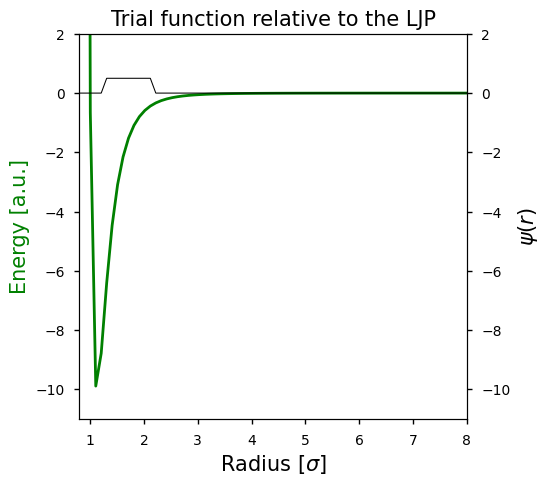

In [30]:
with plt.style.context("seaborn-notebook"):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,5))
    ay = ax.twinx()
    ax.plot(r, potential, color='g', linewidth = 2)
    ay.plot(r, guess, color='k', linewidth = 0.75)

    ax.set_xlim([r[0], r[-1]])
    ax.set_ylim([-11, 2])

    ay.set_xlim([r[0], r[-1]])
    ay.set_ylim([-11, 2])

    ax.set_xlabel("Radius [$\\sigma$]", fontsize=15)
    ax.set_ylabel("Energy [a.u.]", fontsize=15, color='g')

    ay.set_ylabel("$\\psi(r)$", fontsize=15, color='k')

    ax.set_title("Trial function relative to the LJP", fontsize=15)
plt.show()

4. 

In [31]:
def normalize(guess, dr):
    return guess / np.sqrt(np.sum(guess*guess*dr))

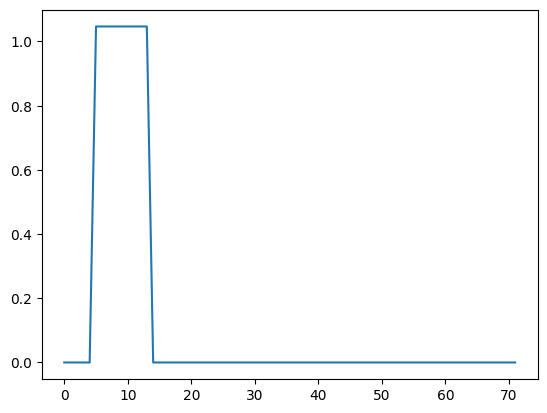

In [32]:
norm = normalize(guess, dr)
plt.plot(norm)
plt.show()

In [33]:
def expectation(guess, potential, r, dr):

    norm_trl = normalize(guess, dr)                   
    
    Ef = dr*(potential[0]*norm_trl[0]**2-(1/2)*norm_trl[0]*
                  (norm_trl[2]+norm_trl[1]-2*norm_trl[0])/dr**2)
    # Calculates the energy at the first index using Forwards-Difference
    Eb = dr*(potential[-1]*norm_trl[-1]**2-(1/2)*norm_trl[-1]*
                  (norm_trl[-1]+norm_trl[-3]-2*norm_trl[-2])/dr**2)
    # Calculates the energy at the last index using Backwards-Difference
    E0 = np.sum(dr*(potential[2:]*norm_trl[1:-1]**2-(1/2)*norm_trl[1:-1]*
                (norm_trl[2:]+norm_trl[0:-2]-2*norm_trl[1:-1])/dr**2))
    # Calculates the energy using the Central-Difference
    return E0+Ef+Eb # Returns the <E>

In [34]:
expectation(guess, potential, r, dr)

9.196238185290932

In [35]:
def variational(guess, potential, r, evaluations):
    dr = np.diff(r)[0]
    E0 = expectation(guess, potential, r, dr)
    store = guess

    counter = 0
    E_after = 0
    while counter<evaluations:
        dpsi = 0.25*(np.random.rand()-0.5)
        
        rdx =  np.random.randint(len(r)-1)
         
        guess[rdx] = guess[rdx]+dpsi
        E_after = expectation(guess, potential, r, dr)
        
        if E_after>E0:
            guess[rdx] = store[rdx]
            print(counter)
        else:
            store[rdx] = guess[rdx]
            E0 = E_after
            print(counter)
            counter+=1
    return normalize(store, dr)

In [36]:
y = variational(guess, potential, r, 200)
plt.plot(y)
plt.show()

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


KeyboardInterrupt: 

In [ ]:
def variational_working(un_trl:np.array, r_left:float, r_right:float, dr:float, length:int, epsilon:float, sigma:float, N:int):
    # Defines the variational method
    trl_old = np.zeros(length)
    # Creates a back_up wavefunction
    E0 = expectation(un_trl, potential, r, dr)
    print(E0)
    # Calculates the <E> for the input trial wave function
    for j in range(length): 
        # Copies the input wavefunction to the back-up wavefunction
        trl_old[j] = un_trl[j]
    E_guess = 0 
    # Initializes the guess energy
    i = 0 
    # Initializes the counter
    E_test_g = np.zeros(N) 
    # Creates an empty array to store energy values as a function of N
    while i < N: 
        # Loops while i<N
        k = np.random.randint(0, length-1) 
        # Chooses a random integer in the array
        trl_old[k] = un_trl[k] 
        # Stores each previous successful iteration
        dphi = 0.5*(np.random.rand()-0.5) 
        # Generates a small nudge 
        un_trl[k] = un_trl[k] + dphi 
        # Nudges the wavefunction at the k_th index
        
        E_guess = expectation(guess, potential, r, dr) 
        # Checks the <E> of this nudged WF
        ##### FOR DEBUGGING #####
        #print(i, k, E0, E_guess)
        if E_guess > E0: 
            # If the guess is larger than the original, it discards the 
            # nudged WF
            un_trl[k] = trl_old[k]
        else: 
            # Else, the counter is increased, the new energy replaces the E0 
            # and the Energy guess is added to an array tracking the 
            # convergence
            E_test_g[i] = E_guess    
            i = i+1
            E0 = E_guess
            #### FOR DEBUGGING ####
            #print(i, k, E0, E_guess)
    return  normalize(un_trl, dr) # Returns the normalized calculated WF and a convergence array

8.22655803445964


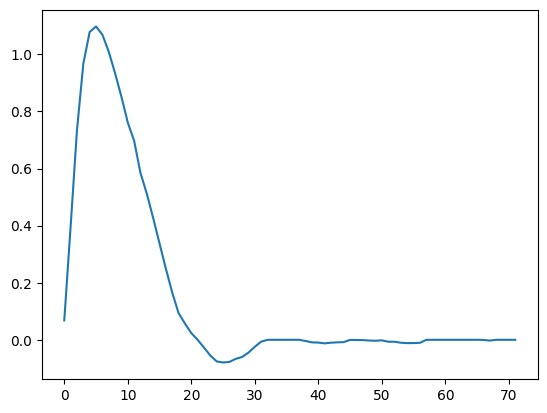

In [ ]:
y = variational_working(guess, r[0], r[-1], dr, length, epsilon, sigma, 300)
plt.plot(y)